# **Primeira parte** - Preparação
---

In [65]:
import sys
!{sys.executable} -m pip install wget spacy pandas_datareader keras tensorflow

  Using cached notebook_as_pdf-0.5.0-py3-none-any.whl (6.5 kB)
  Using cached pyppeteer-0.2.5-py3-none-any.whl (87 kB)
  Using cached PyPDF2-1.26.0.tar.gz (77 kB)
  Using cached pyee-8.1.0-py2.py3-none-any.whl (12 kB)
  Created wheel for PyPDF2: filename=PyPDF2-1.26.0-py3-none-any.whl size=61085 sha256=e9adcb1988328d1c44e91d1418cf5474dd1ba740f6d8a5883c70595029a44148
  Stored in directory: c:\users\gabriel\appdata\local\pip\cache\wheels\b1\1a\8f\a4c34be976825a2f7948d0fa40907598d69834f8ab5889de11
Successfully built PyPDF2


In [2]:
import os, re, wget, requests
from datetime import datetime
import spacy, nltk 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
import scipy.stats as stats
from bs4 import BeautifulSoup
from scipy.stats import variation
from pandas_datareader import data as wb

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# **Segunda parte** - Coleta de dados
---

O seguinte arquivo é lido:

* **Bovespa.csv:** representa uma massa de dados de todas as diárias, de todos os papéis negociados desde Julho-1994 até Abril-2020. A variável destino deste dataframe é a "df_bovespa". Apenas os papeis de BBAS3 e BBDC4 são carregados daqui.


*Nos casos presentes, a especificação antecipada dos tipos de dados foi feita para economizar memória, otimizar o carregamento e evitar a geração de alertas de uso excessivo de memória. Quanto a este último ponto, o objetivo da especificação do atributo "low_memory" como "false" é o mesmo.*

In [3]:
df_bovespa = pd.read_csv(r"Bovespa.csv", dtype={\
    "Date": "string", "Codneg": "string", "Open": float, "Max": float, "Min": float, "Med": float, "Close": float,\
    "preofc": float, "Preofv": float, "Totneg": float, "Quatot": int}, low_memory = False)

#### Carregando dados de ITUB4

Optou-se, para esta empresa, utilizar dados de outra fonte, em atendimento aos requisitos do trabalho. Inicia-se obtendo dados brutos através da API do Yahoo Finances, utilizando o Pandas DataReader:

In [4]:
df_itub4 = wb.DataReader('ITUB4.SA', data_source='yahoo', start='2010-1-1', end='2019-12-31')

# **Terceira parte** - Processamento/tratamento de dados
---

#### Validando valores, a procura de nulos que precisem ser tratados

In [5]:
df_bovespa.isnull().sum(axis=0)

TypeReg       0
Date          0
BDICode       0
Codneg        0
MarketType    0
Company       4
Spec          4
Prazot        0
Currency      0
Open          0
Max           0
Min           0
Med           0
Close         0
Preofc        0
Preofv        0
Totneg        0
Quatot        0
dtype: int64

A igualdade entre o número de entradas e o número de não-nulos em campos relevantes indica que este dataset não precisa de tratamento para ajustar valores omissos. As colunas "Company" e "Spec" serão posteriormente removidas.

#### Criando funções de apoio para preparação, parsing e ajustes dos dados

In [6]:
def processar_dataframe_bovespa(dataset, codigo):
    
    # Filtrando pelo código informado
    dataset.drop(dataset.loc[dataset["Codneg"] != codigo].index, inplace = True)
    
    # Removendo colunas desnecessárias para a análise
    dataset.drop(columns=["TypeReg", "BDICode", "MarketType", "Company", "Spec", "Prazot",\
                          "Currency", "Preofc", "Preofv", "Quatot"], inplace = True)
    
    # Processando datas
    dataset['Date'] =  pd.to_datetime(dataset['Date'], format = '%Y%m%d')
    dataset['DateAsNumber'] = dataset.Date.apply(mdates.date2num)
    
    # Atualizando o índice com a data
    dataset.index = dataset['Date']
    
    # Calculando o retorno diário dos papéis (com base no valor de fechamento, ou "Close")
    dataset['Retorno (%)'] = dataset["Close"].pct_change() * 100
    
    return dataset

#### Separando dataset por cada uma das empresas a ser analisadas

Como descrito no trabalho, as empresas são:

* Banco do Brasil (BBAS3)
* Bradesco (BBDC4)
* Itaú (ITUB4)

Os dados de ITUB4 foram carregados de outra fonte, e não precisam passar por este processamento (adaptado apenas ao arquivo CSV).

In [7]:
df_bbas3 = processar_dataframe_bovespa(df_bovespa.copy(deep = True), "BBAS3")
df_bbdc4 = processar_dataframe_bovespa(df_bovespa.copy(deep = True), "BBDC4")

#### Restringindo faixa de dados

In [8]:
df_bbas3 = df_bbas3.loc["2010-01-01":"2019-12-31"]
df_bbdc4 = df_bbdc4.loc["2010-01-01":"2019-12-31"]

<ipython-input-8-77d712cf66ff>:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_bbas3 = df_bbas3.loc["2010-01-01":"2019-12-31"]
<ipython-input-8-77d712cf66ff>:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_bbdc4 = df_bbdc4.loc["2010-01-01":"2019-12-31"]


Normalizando os dados, seguindo o padrão de colunas e formatos apresentado pelo outro *dataset*

In [9]:
# Renomeando colunas
df_itub4 = df_itub4.rename(columns = {"High": "Max", "Low": "Min"})

# Processando datas
df_itub4['Date'] =  pd.to_datetime(df_itub4.index, format = '%Y%m%d')
df_itub4['DateAsNumber'] = df_itub4.Date.apply(mdates.date2num)

# Atualizando o índice com a data
df_itub4.index = df_itub4['Date']

# Calculando o retorno diário dos papéis (com base no valor de fechamento, ou "Close")
df_itub4['Retorno (%)'] = df_itub4["Close"].pct_change() * 100

Agora, colhendo brevemente informações sobre os três datasets:

In [10]:
df_bbas3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2472 entries, 2010-01-04 to 2019-12-30
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          2472 non-null   datetime64[ns]
 1   Codneg        2472 non-null   string        
 2   Open          2472 non-null   float64       
 3   Max           2472 non-null   float64       
 4   Min           2472 non-null   float64       
 5   Med           2472 non-null   float64       
 6   Close         2472 non-null   float64       
 7   Totneg        2472 non-null   float64       
 8   DateAsNumber  2472 non-null   float64       
 9   Retorno (%)   2472 non-null   float64       
dtypes: datetime64[ns](1), float64(8), string(1)
memory usage: 212.4 KB


In [11]:
df_bbdc4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2472 entries, 2010-01-04 to 2019-12-30
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          2472 non-null   datetime64[ns]
 1   Codneg        2472 non-null   string        
 2   Open          2472 non-null   float64       
 3   Max           2472 non-null   float64       
 4   Min           2472 non-null   float64       
 5   Med           2472 non-null   float64       
 6   Close         2472 non-null   float64       
 7   Totneg        2472 non-null   float64       
 8   DateAsNumber  2472 non-null   float64       
 9   Retorno (%)   2472 non-null   float64       
dtypes: datetime64[ns](1), float64(8), string(1)
memory usage: 212.4 KB


In [12]:
df_itub4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2478 entries, 2010-01-04 to 2019-12-30
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Max           2478 non-null   float64       
 1   Min           2478 non-null   float64       
 2   Open          2478 non-null   float64       
 3   Close         2478 non-null   float64       
 4   Volume        2478 non-null   float64       
 5   Adj Close     2478 non-null   float64       
 6   Date          2478 non-null   datetime64[ns]
 7   DateAsNumber  2478 non-null   float64       
 8   Retorno (%)   2477 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 193.6 KB


# **Quarta parte** - Análise e exploração dos dados
---

### Análise exploratória - Banco do Brasil (BBAS3)

#### Pergunta individual 1 - Em qual dia aconteceu o pior retorno diário, e qual foi este valor?

Localizando no dataframe o dia em específico, observamos que foi em 15 de Março de 2016, quando ocorreu uma queda de 21,17% do valor dos papéis com relação ao dia anterior:

In [13]:
df_bbas3.loc[df_bbas3["Retorno (%)"].idxmin()]

Date            2016-03-15 00:00:00
Codneg                        BBAS3
Open                          20.51
Max                           20.65
Min                            17.5
Med                           18.89
Close                          17.5
Totneg                      64437.0
DateAsNumber                16875.0
Retorno (%)              -21.171171
Name: 2016-03-15 00:00:00, dtype: object

Plotando gráfico, para visualização de todo este histórico de retornos diários relativos:

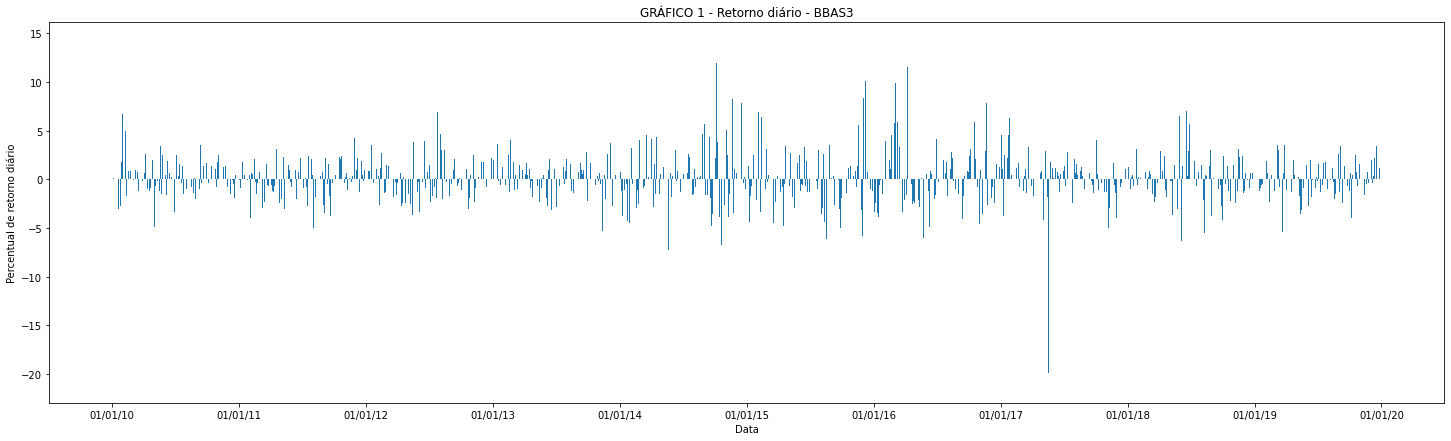

In [14]:
# Preparando objetos
fig, ax = plt.subplots(figsize=(25, 7))

# Adicionando dados relativos aos eixos X e Y
ax.bar(df_bbas3.index,
       df_bbas3["Retorno (%)"])

# Personalizando gráfico
ax.set(xlabel="Data",
       ylabel="Percentual de retorno diário",
       title="GRÁFICO 1 - Retorno diário - BBAS3")

# Formatando datas para exibição
date_form = DateFormatter("%d/%m/%y")
ax.xaxis.set_major_formatter(date_form)

plt.show()

Não foi possível apurar o evento que ocasionou oscilação tão brusca apenas naquele dia.

Por fim, criamos a distribuição de frequência destes dados, para melhor entendermos como se comportam estes retornos diários:

<AxesSubplot:title={'center':'GRÁFICO 2 - Distribuição de frequência de retornos diários - BBAS3'}, xlabel='Retorno (%)', ylabel='Frequência'>

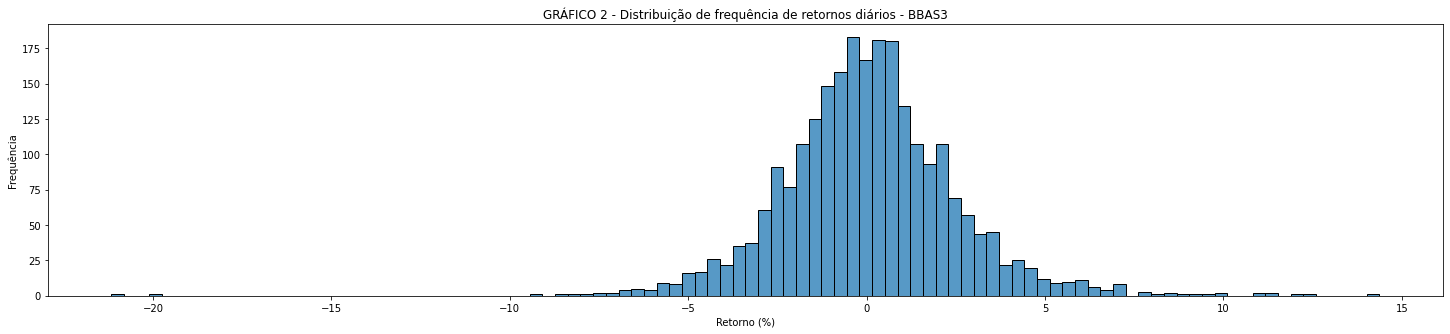

In [15]:
fig, ax1 = plt.subplots(1, 1, figsize=(25, 5))
ax1.set(xlabel="Retorno (%)",
       ylabel="Frequência",
       title="GRÁFICO 2 - Distribuição de frequência de retornos diários - BBAS3")
sns.histplot(df_bbas3["Retorno (%)"].dropna(), bins=100, ax=ax1)

Extrapolando a proposta desta pergunta, aproveitamos para visualizar via **boxplot** a variação trimestral, além da curva de tendência do retorno diário. Desta vez não do retorno diário, mas do valor de fechamento das negociações - já que o dado anterior, neste tipo de ferramenta de visualização ("boxplot"), não nos traz novas informações claras:

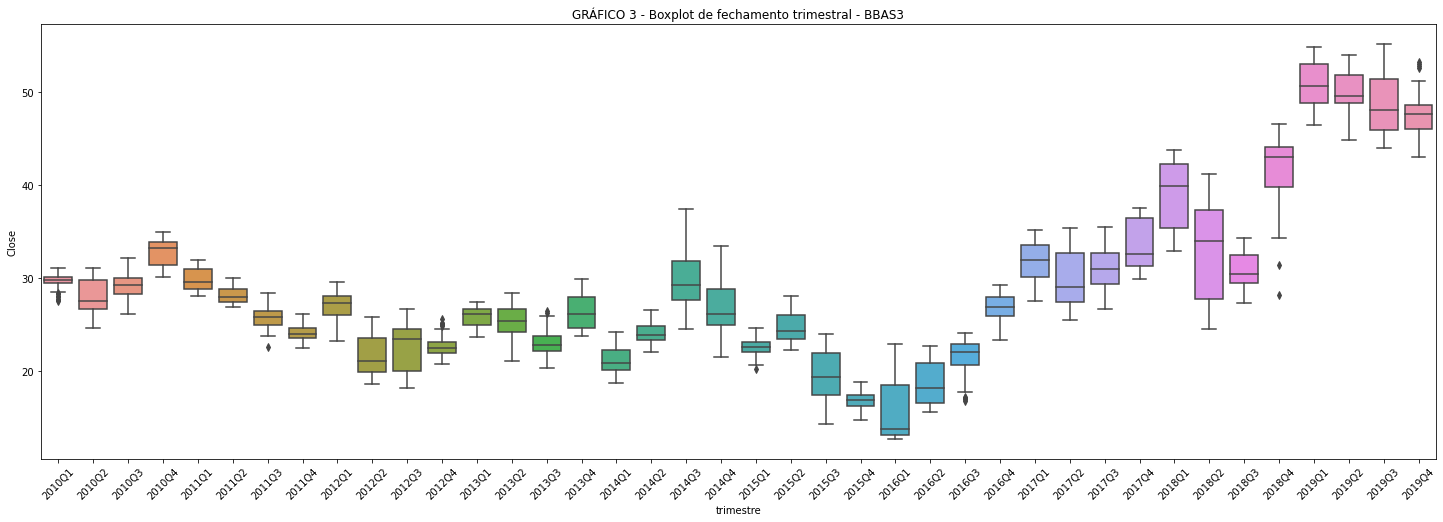

In [16]:
fig, ax2 = plt.subplots(1, 1, figsize=(25, 8))
df_bbas3['trimestre'] = df_bbas3.index.to_period('Q')
plt.xticks(rotation=45)
ax2.set(xlabel="Retorno",
       ylabel="Trimestre",
       title="GRÁFICO 3 - Boxplot de fechamento trimestral - BBAS3")
g = sns.boxplot(x = 'trimestre', y = 'Close', data = df_bbas3, ax = ax2)

[Text(0.5, 6.79999999999999, 'Data'),
 Text(10.050000000000004, 0.5, 'Fechamento'),
 Text(0.5, 1.0, 'GRÁFICO 4 - Valores de de fechamentos diários e curva de tendência')]

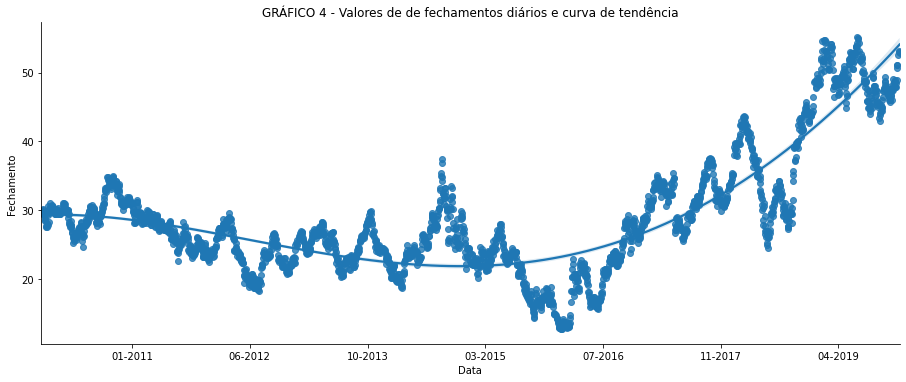

In [17]:
lm = sns.lmplot(x = 'DateAsNumber', y = 'Close', data=df_bbas3, aspect=2.5, order=4)
lm.ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax3 = plt.gca()
ax3.set(xlabel="Data",
       ylabel="Fechamento",
       title = "GRÁFICO 4 - Valores de de fechamentos diários e curva de tendência")

A sensível mas ainda assim notável ascensão positiva pós-2015 indica existência de uma sólida tendência de ganhos nos últimos anos - a qual já pode estar ficando saturada.

#### Pergunta individual 2 - Em qual dia aconteceu o melhor retorno diário, e qual foi este valor?

Localizando no dataframe o dia em específico, observamos que foi em 17 de Março de 2016, quando ocorreu a valorização de 14,37% do valor dos papéis com relação ao dia anterior:

In [18]:
df_bbas3.loc[df_bbas3["Retorno (%)"].idxmax()]

Date            2016-03-17 00:00:00
Codneg                        BBAS3
Open                          21.21
Max                           21.35
Min                           19.35
Med                           20.64
Close                         20.69
Totneg                      50455.0
DateAsNumber                16877.0
Retorno (%)               14.372582
trimestre                    2016Q1
Name: 2016-03-17 00:00:00, dtype: object

Utilizando os gráficos 3 e 4, criado no escopo da pergunta anterior, nota-se que o momento foi durante uma curva de tendência ascendente, o que sugere relevância ou coerência do valor observado. É curioso observar que esta maxima histórica foi apenas dois dias após a mínima histórica do período analisado. Ou seja, provavelmente é relacionada a uma correção natural dos valores.

#### Pergunta individual 3 - Quais foram as médias, medianas, variâncias e desvios padrão com relação ao retorno diário?

A média do retorno diário é:

In [19]:
round(df_bbas3["Retorno (%)"].mean(), 2)

0.05

A mediana é:

In [20]:
round(df_bbas3["Retorno (%)"].median(), 2)

0.0

Já a variância destes valores é:

In [21]:
round(df_bbas3["Retorno (%)"].var(), 2)

6.22

Por fim, o desvio padrão do retorno diário é:

In [22]:
round(df_bbas3["Retorno (%)"].std(), 2)

2.49

Sintentizando alguns dos principais dados, pode-se dizer que a média de retorno diário foi de 0,05%, com variação de +- 2,49%. Isto traduz bem o ambiente hostil e caótico das bolsas de valores, e também reflete o quão difícil é analisar e prever informações como o retorno diário. Um investidor que tenha ficado exposto por todo este período experimentou um ganho médio positivo mas apenas considerando que tenha ficado exposto por todo o período analisado. Além disso, o expressivo desvio padrão demonstra que, ainda que seja extremamente difícil, é enorme o potencial de ganhos com as variações que os papeis podem ter em intervalos por vezes diários.

* * * *

## Análise exploratória - Bradesco (BBDC4)

#### Pergunta individual 1 - Em qual dia aconteceu o pior retorno diário, e qual foi este valor?

Localizando no dataframe o dia em específico, observamos que foi em 27 de Março de 2015, quando ocorreu uma queda de 18,98% do valor dos papéis com relação ao dia anterior:

In [23]:
df_bbdc4.loc[df_bbdc4["Retorno (%)"].idxmin()]

Date            2015-03-27 00:00:00
Codneg                        BBDC4
Open                          29.43
Max                           29.43
Min                            28.2
Med                           28.78
Close                          28.6
Totneg                      20079.0
DateAsNumber                16521.0
Retorno (%)               -18.98017
Name: 2015-03-27 00:00:00, dtype: object

Plotando gráfico, para visualização de todo este histórico de retornos diários relativos:

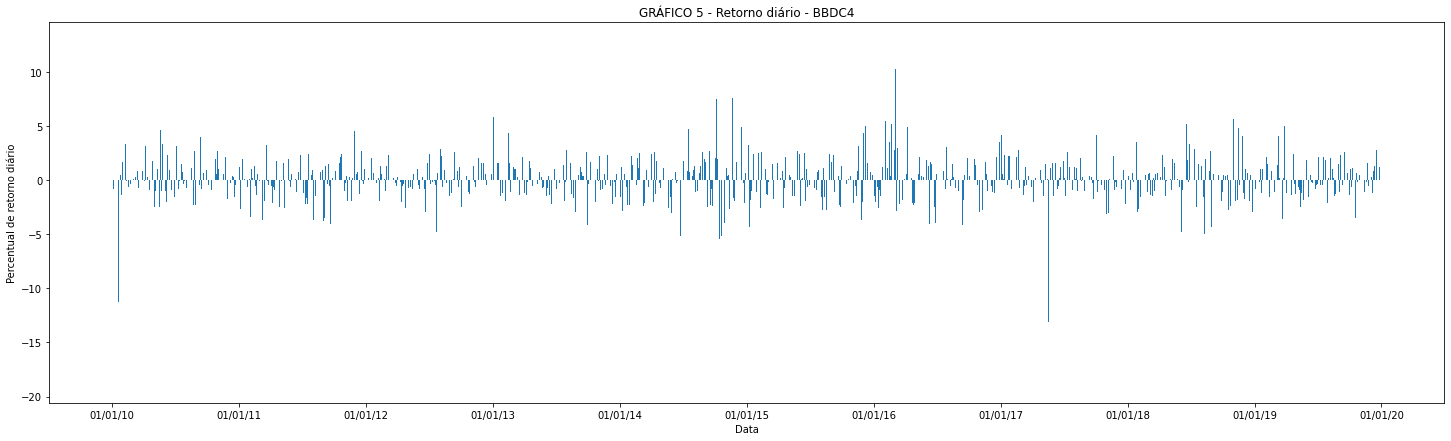

In [24]:
# Preparando objetos
fig, ax = plt.subplots(figsize=(25, 7))

# Adicionando dados relativos aos eixos X e Y
ax.bar(df_bbdc4.index,
       df_bbdc4["Retorno (%)"])

# Personalizando gráfico
ax.set(xlabel="Data",
       ylabel="Percentual de retorno diário",
       title="GRÁFICO 5 - Retorno diário - BBDC4")

# Formatando datas para exibição
date_form = DateFormatter("%d/%m/%y")
ax.xaxis.set_major_formatter(date_form)

plt.show()

Também não foi possível identificar o evento causador de tamanha queda relativa, considerando que pudesse ser algum evento singular e claramente definível. 

A seguir, criamos a distribuição de frequência destes dados, para melhor entendermos como se comportam estes retornos diários:

<AxesSubplot:title={'center':'GRÁFICO 6 - Distribuição de frequência de retornos diários - BBDC4'}, xlabel='Retorno (%)', ylabel='Frequência'>

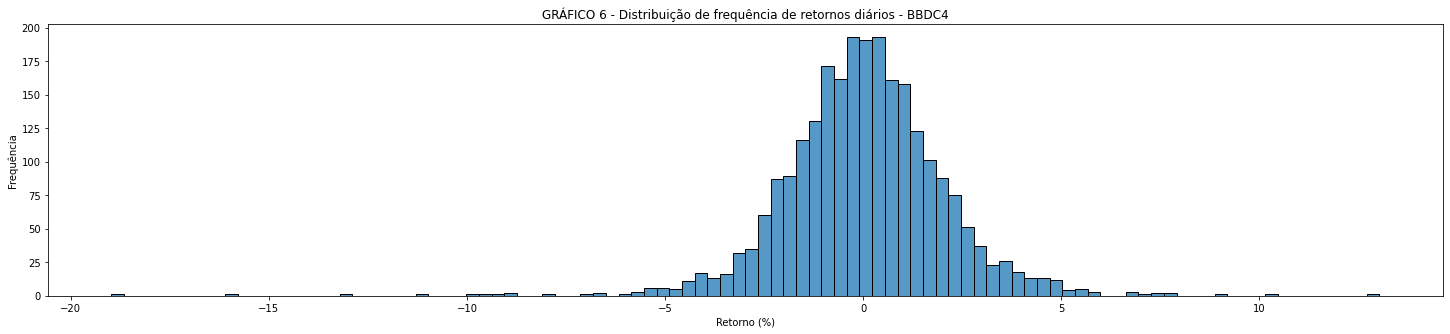

In [25]:
fig, ax1 = plt.subplots(1, 1, figsize=(25, 5))
ax1.set(xlabel="Retorno (%)",
       ylabel="Frequência",
       title="GRÁFICO 6 - Distribuição de frequência de retornos diários - BBDC4")
sns.histplot(df_bbdc4["Retorno (%)"].dropna(), bins=100, ax=ax1)

É interessante observar que, apesar dos valores se distribuirem principalmente em torno de zero, *outliers* aparecem com frequência na faixa negativa - o que pode facilmente assustar os menos experientes.


Mais uma vez extrapolando a proposta desta pergunta, aproveitamos para visualizar via **boxplot** a variação trimestral, além da curva de tendência do retorno diário. Desta vez não do retorno diário, mas do valor de fechamento das negociações - já que o dado anterior, neste tipo de ferramenta de visualização ("boxplot"), não nos traz novas informações claras:

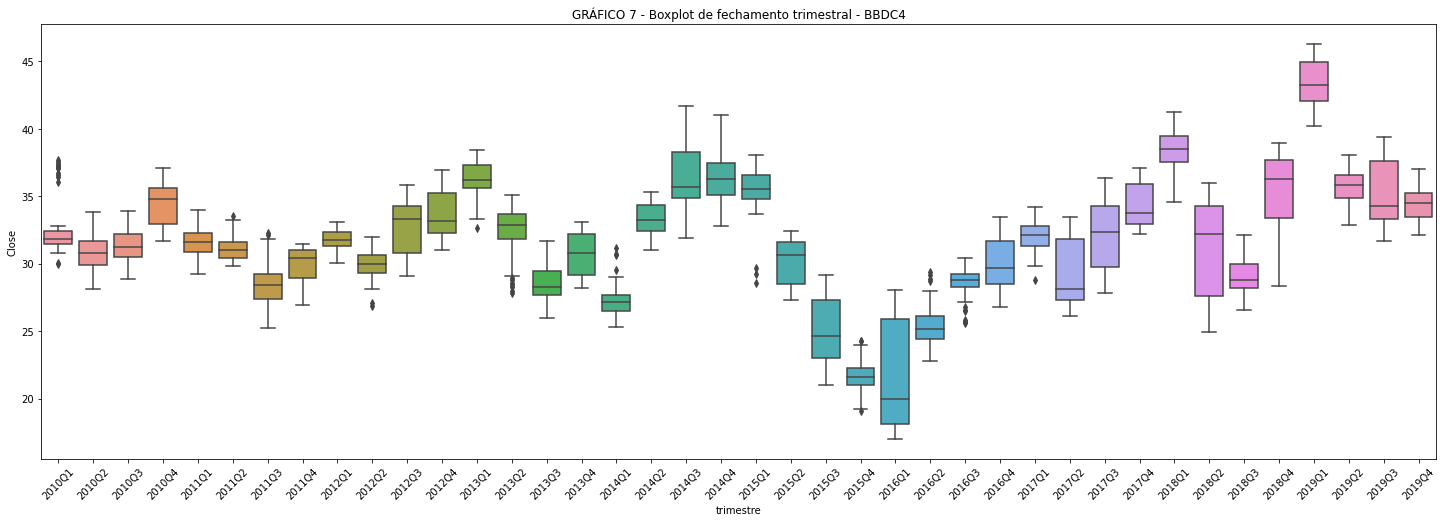

In [26]:
fig, ax2 = plt.subplots(1, 1, figsize=(25, 8))
df_bbdc4['trimestre'] = df_bbdc4.index.to_period('Q')
plt.xticks(rotation=45)
ax2.set(xlabel="Retorno",
       ylabel="Trimestre",
       title="GRÁFICO 7 - Boxplot de fechamento trimestral - BBDC4")
g = sns.boxplot(x = 'trimestre', y = 'Close', data = df_bbdc4, ax = ax2)

[Text(0.5, 6.79999999999999, 'Data'),
 Text(10.050000000000004, 0.5, 'Fechamento'),
 Text(0.5, 1.0, 'GRÁFICO 8 - Valores de de fechamentos diários e curva de tendência')]

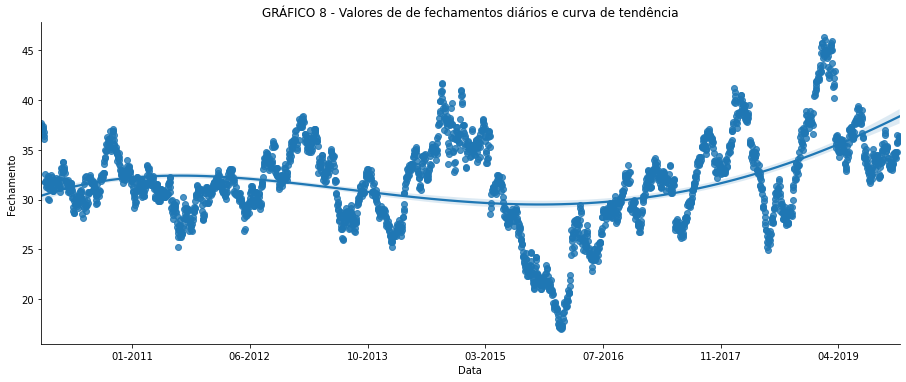

In [27]:
lm = sns.lmplot(x = 'DateAsNumber', y = 'Close', data=df_bbdc4, aspect=2.5, order=4)
lm.ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax3 = plt.gca()
ax3.set(xlabel="Data",
       ylabel="Fechamento",
       title = "GRÁFICO 8 - Valores de de fechamentos diários e curva de tendência")

Extra-se destes gráficos a conclusão da relativa "estabilidade" quando comparado com o papel anterior, e a repetição da tendência positiva à partir de 2016, que pode ser relacionada a um bom momento de todo este segmento do mercado.

#### Pergunta individual 2 - Em qual dia aconteceu o melhor retorno diário, e qual foi este valor?

Pesquisando no dataframe o dia em específico, observamos que foi em 17 de Março de 2016, quando ocorreu a valorização de 13,03% do valor dos papéis com relação ao dia anterior:

In [28]:
df_bbdc4.loc[df_bbdc4["Retorno (%)"].idxmax()]

Date            2016-03-17 00:00:00
Codneg                        BBDC4
Open                           27.2
Max                           27.97
Min                           25.88
Med                           27.06
Close                         27.85
Totneg                      58985.0
DateAsNumber                16877.0
Retorno (%)               13.027597
trimestre                    2016Q1
Name: 2016-03-17 00:00:00, dtype: object

Observa-se que esta data se apresenta aproximadamente no meio da curva de tendência positiva que se iniciou em 2016, e é idêntico ao de BBAS3.

#### Pergunta individual 3 - Quais foram as médias, medianas, variâncias e desvios padrão com relação ao retorno diário?

A média do retorno diário é:

In [29]:
round(df_bbdc4["Retorno (%)"].mean(), 2)

0.02

A mediana é:

In [30]:
round(df_bbdc4["Retorno (%)"].median(), 2)

0.0

Já a variância destes valores é:

In [31]:
round(df_bbdc4["Retorno (%)"].var(), 2)

4.17

Por fim, o desvio padrão do retorno diário é:

In [32]:
round(df_bbdc4["Retorno (%)"].std(), 2)

2.04

Sintentizando alguns dos principais dados, pode-se dizer que a média de retorno diário foi de 0,02%, com variação de +- 2,04%. São valores bem próximos ao do papel anterior, e que expressam a ideia de que os ganhos acumulados podem não ser tão expressivos (apesar da segurança que operar assim pode trazer), e que os riscos nas operações diárias é exponencialmente maior.

* * * *

## Análise exploratória - Itaú (ITUB4)

#### Pergunta individual 1 - Em qual dia aconteceu o pior retorno diário, e qual foi este valor?

Localizando no dataframe o dia em específico, observamos que foi em 18 de Maio de 2017, quando ocorreu uma queda de 12,05% do valor dos papéis com relação ao dia anterior:

In [33]:
df_itub4.loc[df_itub4["Retorno (%)"].idxmin()]

Max                       23.959999
Min                       21.133333
Open                      21.133333
Close                     23.120001
Volume                  104917200.0
Adj Close                 19.534872
Date            2017-05-18 00:00:00
DateAsNumber                17304.0
Retorno (%)              -12.046662
Name: 2017-05-18 00:00:00, dtype: object

Plotando gráfico, para visualização de todo este histórico de retornos diários relativos:

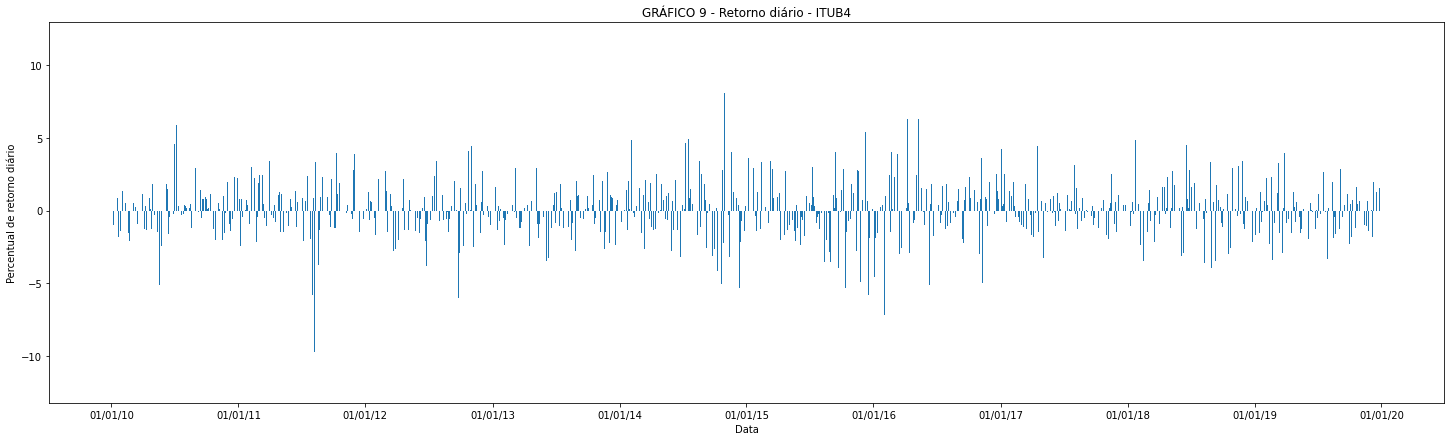

In [34]:
# Preparando objetos
fig, ax = plt.subplots(figsize=(25, 7))

# Adicionando dados relativos aos eixos X e Y
ax.bar(df_itub4.index,
       df_itub4["Retorno (%)"])

# Personalizando gráfico
ax.set(xlabel="Data",
       ylabel="Percentual de retorno diário",
       title="GRÁFICO 9 - Retorno diário - ITUB4")

# Formatando datas para exibição
date_form = DateFormatter("%d/%m/%y")
ax.xaxis.set_major_formatter(date_form)

plt.show()

O evento causador de tamanha oscilação negativa foi o desdobramento das ações, publicado pela companhia naquele período (ITAU, 2018). Não teve, porém, efeito prático no patrimônio dos ivestidores, tal qual ocorreu com o Banco do Brasil alguns anos antes. Por outro lado, já se observa a volatilidade maior que do Bradesco, no retorno diário das ações.

A seguir, criamos a distribuição de frequência destes dados, para melhor entendermos como se comportam estes retornos diários:

<AxesSubplot:title={'center':'GRÁFICO 10 - Distribuição de frequência de retornos diários - ITUB4'}, xlabel='Retorno (%)', ylabel='Frequência'>

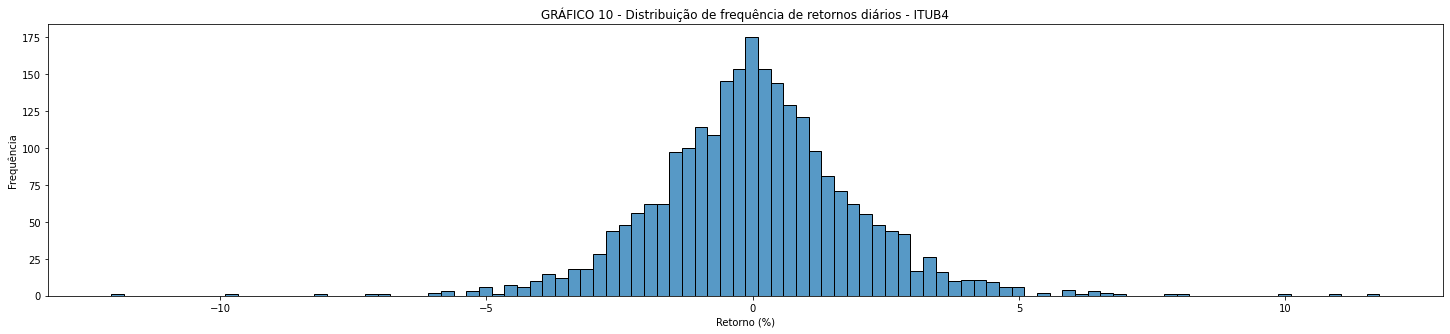

In [35]:
fig, ax1 = plt.subplots(1, 1, figsize=(25, 5))
ax1.set(xlabel="Retorno (%)",
       ylabel="Frequência",
       title="GRÁFICO 10 - Distribuição de frequência de retornos diários - ITUB4")
sns.histplot(df_itub4["Retorno (%)"].dropna(), bins=100, ax=ax1)

A realidade deste papel parece ser um pouco diferente da dos outros dois. Observa-se igualmente uma grande variabilidade, mas sempre girando em torno de zero. Isto simboliza que há a possibilidade de explorar momentos positivos e negativos para auferir ganhos, apesar da dificuldade da atividade. Mas a distribuição se localiza sensivelmente mais ao centro, indicando que *outliers* tem tendências proporicionais de serem positivos ou negativos.

Novamente extrapolando a proposta desta pergunta, aproveitamos para visualizar via **boxplot** a variação trimestral, além da curva de tendência do retorno diário. Também não do retorno diário, mas do valor de fechamento das negociações - já que o dado anterior, neste tipo de ferramenta de visualização ("boxplot"), não nos traz novas informações claras:

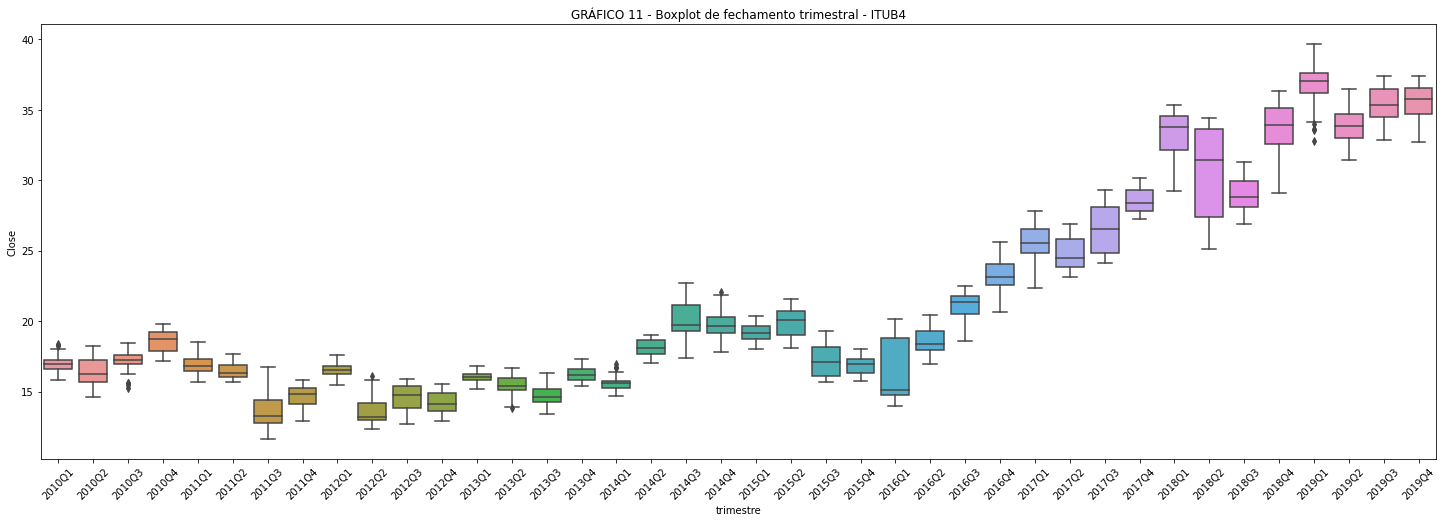

In [36]:
fig, ax2 = plt.subplots(1, 1, figsize=(25, 8))
df_itub4['trimestre'] = df_itub4.index.to_period('Q')
plt.xticks(rotation=45)
ax2.set(xlabel="Retorno",
       ylabel="Trimestre",
       title="GRÁFICO 11 - Boxplot de fechamento trimestral - ITUB4")
g = sns.boxplot(x = 'trimestre', y = 'Close', data = df_itub4, ax = ax2)

[Text(0.5, 6.79999999999999, 'Data'),
 Text(10.050000000000004, 0.5, 'Fechamento'),
 Text(0.5, 1.0, 'GRÁFICO 12 - Valores de de fechamentos diários e curva de tendência')]

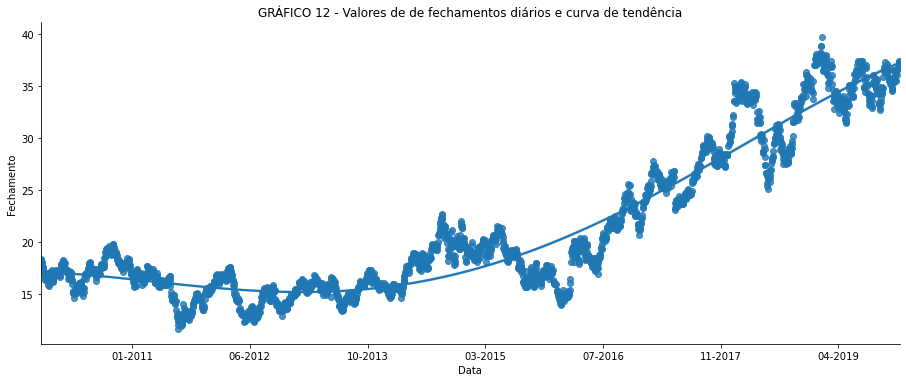

In [37]:
lm = sns.lmplot(x = 'DateAsNumber', y = 'Close', data=df_itub4, aspect=2.5, order=4)
lm.ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax3 = plt.gca()
ax3.set(xlabel="Data",
       ylabel="Fechamento",
       title = "GRÁFICO 12 - Valores de de fechamentos diários e curva de tendência")

A análise de valores de fechamentos é coerente com a de rentabilidade diária ou trimestral. A variabilidade indica ser sensivelmente maior que a do Bradesco, e desde 2015 já sensível curva positiva.

#### Pergunta individual 2 - Em qual dia aconteceu o melhor retorno diário, e qual foi este valor?

Pesquisando no dataframe o dia em específico, observamos que foi em 21 de Maio de 2013, quando ocorreu a valorização de 11,77% do valor dos papéis com relação ao dia anterior:

In [38]:
df_itub4.loc[df_itub4["Retorno (%)"].idxmax()]

Max                       16.448786
Min                       16.023041
Open                      16.338593
Close                     16.443775
Volume                   17863084.0
Adj Close                 11.593596
Date            2013-05-21 00:00:00
DateAsNumber                15846.0
Retorno (%)               11.770349
trimestre                    2013Q2
Name: 2013-05-21 00:00:00, dtype: object

Não podemos descobrir de maneira clara o que aconteceu naquele dia em específico.

#### Pergunta individual 3 - Quais foram as médias, medianas, variâncias e desvios padrão com relação ao retorno diário?

A média do retorno diário é:

In [39]:
round(df_itub4["Retorno (%)"].mean(), 2)

0.05

A mediana é:

In [40]:
round(df_itub4["Retorno (%)"].median(), 2)

0.0

Já a variância destes valores é:

In [41]:
round(df_itub4["Retorno (%)"].var(), 2)

3.52

Por fim, o desvio padrão do retorno diário é:

In [42]:
round(df_itub4["Retorno (%)"].std(), 2)

1.88

A média bem próxima de zero, mais uma vez, indica que deixar as ações paradas por muito tempo não é útil para auferir ganhos significativos. Já o desvio padrão em 1,88% repete mais uma vez a indicação que oscilações *intraday* trazem, de forma idêntica, riscos e potenciais de ganhos notáveis.

* * * *
* * * *
* * * *

## Perguntas comparativas

#### Pergunta 1 - Qual foi o ativo mais/menos arriscado?

Loque (2020, s.p.) nos ensina que "é típico na área de finanças considerar o risco como sendo o desvio padrão, que expressa o grau de dispersão de um conjunto de dados". Assim, os apresentamos:

In [43]:
print('Desvio padrão BBAS3: ' + str(round(df_bbas3["Retorno (%)"].std(), 2)))
print('Desvio padrão BBDC4: ' + str(round(df_bbdc4["Retorno (%)"].std(), 2)))
print('Desvio padrão ITUB4: ' + str(round(df_itub4["Retorno (%)"].std(), 2)))

Desvio padrão BBAS3: 2.49
Desvio padrão BBDC4: 2.04
Desvio padrão ITUB4: 1.88


Tem-se então a resposta: o mais arriscado é BBAS3, e o menos arriscado é ITUB4. É uma conclusão rasa, como poderá ser observado na pergunta a seguir:

#### Pergunta 2 - Qual foi o ativo que gerou o maior retorno ao longo de todo o período?

Comparando os valores do primeiro e do último dia da faixa analisada, observa-se:

In [44]:
print('Retorno BBAS3: ' + str(round(((df_bbas3.iloc[-1]["Close"] / df_bbas3.iloc[0]["Close"]) - 1) * 100, 2)) + "%")
print('Retorno BBDC4: ' + str(round(((df_bbdc4.iloc[-1]["Close"] / df_bbdc4.iloc[0]["Close"]) - 1) * 100, 2)) + "%")
print('Retorno ITUB4: ' + str(round(((df_itub4.iloc[-1]["Close"] / df_itub4.iloc[0]["Close"]) - 1) * 100, 2)) + "%")

Retorno BBAS3: 76.66%
Retorno BBDC4: -4.06%
Retorno ITUB4: 103.08%


Os dados revelam que o melhor retorno acumulado foi do ITUB. Já o pior, de BBDC4. Estes valores se contrapõem aos da pergunta anterior, mas reforça-se que eles não são naturalmente opostos - ou seja, maiores riscos não significam necessariamente maiores retornos!

* * * *
* * * *
* * * *

# **Quinta parte** - Aplicação de modelo de machine learning
---

## Aplicação de modelo de aprendizado de máquina

In [45]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

Preparando os datasets de treinamento e com os valores reais (para comparação, ao fim), para cada empresa:

In [46]:
df_treinamento_bbas3 = df_bbas3.loc["2010-01-01":"2018-12-31"].drop(columns=["Date"])
df_treinamento_bbas3 = df_treinamento_bbas3.reset_index().drop(columns=["Med", "Codneg", "DateAsNumber", "Retorno (%)", "trimestre"])
df_valores_reais_bbas3 = df_bbas3.loc["2019-01-01":"2019-12-31"].drop(columns=["Date"])
df_valores_reais_bbas3 = df_valores_reais_bbas3.reset_index().drop(columns=["Med", "Codneg", "DateAsNumber", "Retorno (%)", "trimestre"])

df_treinamento_bbdc4 = df_bbdc4.loc["2010-01-01":"2018-12-31"].drop(columns=["Date"])
df_treinamento_bbdc4 = df_treinamento_bbdc4.reset_index().drop(columns=["Med", "Codneg", "DateAsNumber", "Retorno (%)", "trimestre"])
df_valores_reais_bbdc4 = df_bbdc4.loc["2019-01-01":"2019-12-31"].drop(columns=["Date"])
df_valores_reais_bbdc4 = df_valores_reais_bbdc4.reset_index().drop(columns=["Med", "Codneg", "DateAsNumber", "Retorno (%)", "trimestre"])

df_treinamento_itub4 = df_itub4.loc["2010-01-01":"2018-12-31"].drop(columns=["Date"])
df_treinamento_itub4 = df_treinamento_itub4.reset_index().drop(columns=["DateAsNumber", "Retorno (%)", "trimestre", "Adj Close"])
df_valores_reais_itub4 = df_itub4.loc["2019-01-01":"2019-12-31"].drop(columns=["Date"])
df_valores_reais_itub4 = df_valores_reais_itub4.reset_index().drop(columns=["DateAsNumber", "Retorno (%)", "trimestre", "Adj Close"])

Padronizando os datasets, que tem origens diferentes

In [47]:
df_treinamento_bbas3.rename(columns={"Totneg": "Volume"}, inplace=True)
df_treinamento_bbdc4.rename(columns={"Totneg": "Volume"}, inplace=True)
df_treinamento_itub4 = df_treinamento_itub4[["Date", "Open", "Max", "Min", "Close", "Volume"]]

Para treinar o modelo, é necessário converter o dataframe para um array, com os dados relevantes. Optamos pelo valor de fechamento das ações:

In [48]:
array_treinamento_bbas3 = df_treinamento_bbas3.iloc[:,4:5].values
array_treinamento_bbdc4 = df_treinamento_bbdc4.iloc[:,4:5].values
array_treinamento_itub4 = df_treinamento_itub4.iloc[:,4:5].values

Normalizando os dados de cada dataframe de treinamento, para aumentar a velocidade do processamento do algoritmo:

In [49]:
normalizador = MinMaxScaler(feature_range = (0,1))
array_treinamento_bbas3_normalizado = normalizador.fit_transform(array_treinamento_bbas3)
array_treinamento_bbdc4_normalizado = normalizador.fit_transform(array_treinamento_bbdc4)
array_treinamento_itub4_normalizado = normalizador.fit_transform(array_treinamento_itub4)

Criando estruturas para treinamento, de cada um dos três papéis. Cria-se pequenos "grupos" ("batches") de 60 valores/dia (sugerido considerando o tamanho da amostra) cada um, armazenando estes dados em um objeto "eixo X". Já no eixo Y, armazena-se os "labels" equivalentes a cada um dos grupos/"batches".

In [50]:
X_train_bbas3 = []
X_train_bbdc4 = []
X_train_itub4 = []
Y_train_bbas3 = []
Y_train_bbdc4 = []
Y_train_itub4 = []

for i in range (60, len(array_treinamento_bbas3_normalizado)):
    X_train_bbas3.append(array_treinamento_bbas3_normalizado[i-60:i,0]) 
    Y_train_bbas3.append(array_treinamento_bbas3_normalizado[i,0])
    
for i in range (60, len(array_treinamento_bbdc4_normalizado)):
    X_train_bbdc4.append(array_treinamento_bbas3_normalizado[i-60:i,0]) 
    Y_train_bbdc4.append(array_treinamento_bbas3_normalizado[i,0])
    
for i in range (60, len(array_treinamento_itub4_normalizado)):
    X_train_itub4.append(array_treinamento_itub4_normalizado[i-60:i,0]) 
    Y_train_itub4.append(array_treinamento_itub4_normalizado[i,0])


X_train_bbas3,Y_train_bbas3 = np.array(X_train_bbas3),np.array(Y_train_bbas3)
X_train_bbdc4,Y_train_bbdc4 = np.array(X_train_bbdc4),np.array(Y_train_bbdc4)
X_train_itub4,Y_train_itub4 = np.array(X_train_itub4),np.array(Y_train_itub4)

Reorganizando cada um dos vetores de treinamento para o modelo de 3 eixos utilizado no LSTM:

In [51]:
X_train_bbas3 = np.reshape(X_train_bbas3, (X_train_bbas3.shape[0], X_train_bbas3.shape[1], 1))
X_train_bbdc4 = np.reshape(X_train_bbdc4, (X_train_bbdc4.shape[0], X_train_bbdc4.shape[1], 1))
X_train_itub4 = np.reshape(X_train_itub4, (X_train_itub4.shape[0], X_train_itub4.shape[1], 1))

Construindo os modelos, através da adição de camadas no LSTM

In [52]:
regressor_bbas3 = Sequential()
regressor_bbdc4 = Sequential()
regressor_itub4 = Sequential()

regressor_bbas3.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_bbas3.shape[1], 1)))
regressor_bbas3.add(Dropout(0.2))
regressor_bbas3.add(LSTM(units = 50, return_sequences = True))
regressor_bbas3.add(Dropout(0.2))
regressor_bbas3.add(LSTM(units = 50, return_sequences = True))
regressor_bbas3.add(Dropout(0.2))
regressor_bbas3.add(LSTM(units = 50))
regressor_bbas3.add(Dropout(0.2))
regressor_bbas3.add(Dense(units = 1))

regressor_bbdc4.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_bbdc4.shape[1], 1)))
regressor_bbdc4.add(Dropout(0.2))
regressor_bbdc4.add(LSTM(units = 50, return_sequences = True))
regressor_bbdc4.add(Dropout(0.2))
regressor_bbdc4.add(LSTM(units = 50, return_sequences = True))
regressor_bbdc4.add(Dropout(0.2))
regressor_bbdc4.add(LSTM(units = 50))
regressor_bbdc4.add(Dropout(0.2))
regressor_bbdc4.add(Dense(units = 1))

regressor_itub4.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_itub4.shape[1], 1)))
regressor_itub4.add(Dropout(0.2))
regressor_itub4.add(LSTM(units = 50, return_sequences = True))
regressor_itub4.add(Dropout(0.2))
regressor_itub4.add(LSTM(units = 50, return_sequences = True))
regressor_itub4.add(Dropout(0.2))
regressor_itub4.add(LSTM(units = 50))
regressor_itub4.add(Dropout(0.2))
regressor_itub4.add(Dense(units = 1))

Executando os modelos de treinamento, passando os valores preparados anteriormente:

In [53]:
regressor_bbas3.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor_bbdc4.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor_itub4.compile(optimizer = 'adam', loss = 'mean_squared_error')
historico_bbas3 = regressor_bbas3.fit(X_train_bbas3, Y_train_bbas3, epochs = 20, batch_size = 32)
historico_bbdc4 = regressor_bbdc4.fit(X_train_bbdc4, Y_train_bbdc4, epochs = 20, batch_size = 32)
historico_itub4 = regressor_itub4.fit(X_train_itub4, Y_train_itub4, epochs = 20, batch_size = 32)

Epoch 1/20
68/68 [==============================] - 30s 88ms/step - loss: 0.0398
Epoch 2/20
68/68 [==============================] - 5s 80ms/step - loss: 0.0068
Epoch 3/20
68/68 [==============================] - 5s 81ms/step - loss: 0.0059
Epoch 4/20
68/68 [==============================] - 5s 80ms/step - loss: 0.0045
Epoch 5/20
68/68 [==============================] - 5s 79ms/step - loss: 0.0046
Epoch 6/20
68/68 [==============================] - 5s 77ms/step - loss: 0.0043
Epoch 7/20
68/68 [==============================] - 6s 83ms/step - loss: 0.0040
Epoch 8/20
68/68 [==============================] - 5s 79ms/step - loss: 0.0036
Epoch 9/20
68/68 [==============================] - 5s 76ms/step - loss: 0.0035
Epoch 10/20
68/68 [==============================] - 5s 75ms/step - loss: 0.0034
Epoch 11/20
68/68 [==============================] - 5s 76ms/step - loss: 0.0032
Epoch 12/20
68/68 [==============================] - 5s 79ms/step - loss: 0.0031
Epoch 13/20
68/68 [=================

Analisando as perdas acumuladas pelo modelo preditivo ao longo do tempo de treinamento:

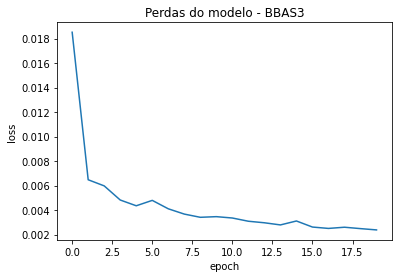

In [54]:
plt.plot(historico_bbas3.history["loss"])
plt.title("Perdas do modelo - BBAS3")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

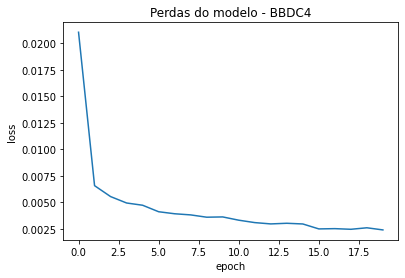

In [55]:
plt.plot(historico_bbdc4.history["loss"])
plt.title("Perdas do modelo - BBDC4")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

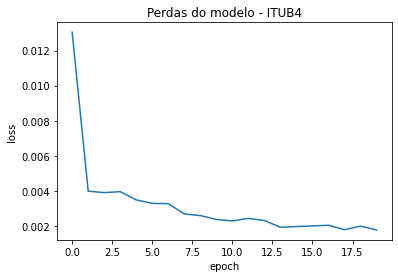

In [56]:
plt.plot(historico_itub4.history["loss"])
plt.title("Perdas do modelo - ITUB4")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

Preparando dados de input para o modelo de predição

In [57]:
df_dados_teste_bbas3 = df_valores_reais_bbas3.iloc[:,4:5]
Y_teste_bbas3 = df_dados_teste_bbas3.iloc[60:,0:].values 
inputFechamento_normalizado_bbas3 = normalizador.transform(df_dados_teste_bbas3.iloc[:,0:].values)

df_dados_teste_bbdc4 = df_valores_reais_bbdc4.iloc[:,4:5]
Y_teste_bbdc4 = df_dados_teste_bbdc4.iloc[60:,0:].values 
inputFechamento_normalizado_bbdc4 = normalizador.transform(df_dados_teste_bbdc4.iloc[:,0:].values)

df_dados_teste_itub4 = df_valores_reais_itub4.iloc[:,4:5]
Y_teste_itub4 = df_dados_teste_itub4.iloc[60:,0:].values 
inputFechamento_normalizado_itub4 = normalizador.transform(df_dados_teste_itub4.iloc[:,0:].values)

In [58]:
X_teste_bbas3 = []
for i in range(60,len(df_dados_teste_bbas3)):  
    X_teste_bbas3.append(inputFechamento_normalizado_bbas3[i-60:i,0])
X_teste_bbas3 = np.array(X_teste_bbas3)
X_teste_bbas3 = np.reshape(X_teste_bbas3,(X_teste_bbas3.shape[0],X_teste_bbas3.shape[1],1))

X_teste_bbdc4 = []
for i in range(60,len(df_dados_teste_bbdc4)):  
    X_teste_bbdc4.append(inputFechamento_normalizado_bbdc4[i-60:i,0])
X_teste_bbdc4 = np.array(X_teste_bbdc4)
X_teste_bbdc4 = np.reshape(X_teste_bbdc4,(X_teste_bbdc4.shape[0],X_teste_bbdc4.shape[1],1))

X_teste_itub4 = []
for i in range(60,len(df_dados_teste_itub4)):  
    X_teste_itub4.append(inputFechamento_normalizado_itub4[i-60:i,0])
X_teste_itub4 = np.array(X_teste_itub4)
X_teste_itub4 = np.reshape(X_teste_itub4,(X_teste_itub4.shape[0],X_teste_itub4.shape[1],1))

Executando modelo para calcular dados previstos para o período escolhido (2019):

In [59]:
valores_previstos_bbas3 = regressor_bbas3.predict(X_teste_bbas3)
valores_previstos_bbas3 = normalizador.inverse_transform(valores_previstos_bbas3)

valores_previstos_bbdc4 = regressor_bbdc4.predict(X_teste_bbdc4)
valores_previstos_bbdc4 = normalizador.inverse_transform(valores_previstos_bbdc4)

valores_previstos_itub4 = regressor_itub4.predict(X_teste_itub4)
valores_previstos_itub4 = normalizador.inverse_transform(valores_previstos_itub4)

Exibindo gráficos para análise

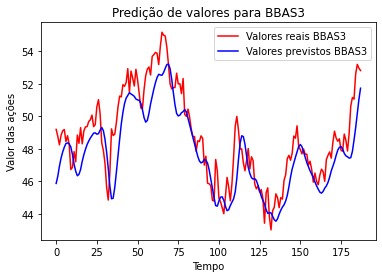

In [60]:
plt.plot(Y_teste_bbas3, color = "red", label = "Valores reais BBAS3")
plt.plot(valores_previstos_bbas3, color = "blue", label = "Valores previstos BBAS3")
plt.title("Predição de valores para BBAS3")
plt.xlabel("Tempo")
plt.ylabel("Valor das ações")
plt.legend()

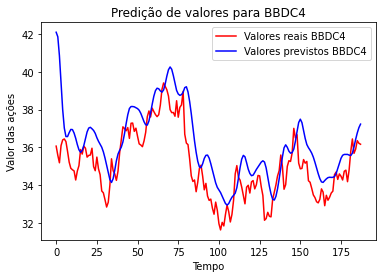

In [61]:
plt.plot(Y_teste_bbdc4, color = "red", label = "Valores reais BBDC4")
plt.plot(valores_previstos_bbdc4, color = "blue", label = "Valores previstos BBDC4")
plt.title("Predição de valores para BBDC4")
plt.xlabel("Tempo")
plt.ylabel("Valor das ações")
plt.legend()

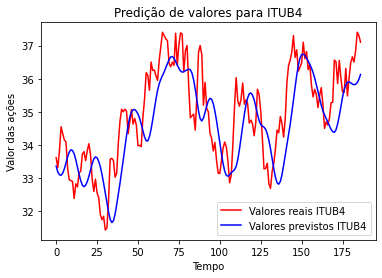

In [62]:
plt.plot(Y_teste_itub4, color = "red", label = "Valores reais ITUB4")
plt.plot(valores_previstos_itub4, color = "blue", label = "Valores previstos ITUB4")
plt.title("Predição de valores para ITUB4")
plt.xlabel("Tempo")
plt.ylabel("Valor das ações")
plt.legend()